<a href="https://colab.research.google.com/github/Vuducdung28/Coursera_Capstone/blob/main/Toronto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import requests
from bs4 import BeautifulSoup
print("Libraries imported")

Libraries imported


<h1>Fetching Data from Wikipedia</h1>

In [4]:
html_data = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(html_data, 'html.parser')
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.shape

(103, 3)

<h1>Toronto Data from CSV</h1>

In [5]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv'
geo_data = pd.read_csv(url)
geo_data.reset_index()
geo_data.columns = ['PostalCode','Latitude','Longitude']
big_df = pd.merge(df, geo_data, on = 'PostalCode')

Clustering neighborhood and generating Toronto neighborhood map

In [6]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
from geopy.geocoders import Nominatim
print("Libraries imported")

Libraries imported


Getting geographical location of Toronto for map visualization 




In [7]:
address = 'Toronto, ON'
geolocator = Nominatim(user_agent = 'toronto_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


<h1>Map visualization of Toronto, with blue markers representing boroughs that contain the word "Toronto"</h1>

In [ ]:
#@title Display map of Toronto
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
big_df = big_df[big_df["Borough"].str.contains("Toronto")].reset_index(drop=True)
for lat, lng, borough, neighborhood in zip(big_df['Latitude'], big_df['Longitude'], big_df['Borough'], big_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

<h2> Problem: Where in Toronto should first-time tourists visit? </h2>


<h1>Data from Foursquare API</h1>

Define Foursquare Credentials and Version

In [9]:
import getpass
CLIENT_ID = getpass.getpass()
CLIENT_SECRET = getpass.getpass()
ACCESS_TOKEN = getpass.getpass()
VERSION = '20210507' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

··········
··········
··········


Define a function to convert the Neighborhood string to list, then use explode('Neighborhood') on big_df to get the geographical location for each Neighborhood

In [10]:
#@title Default title text
# Function to convert neighborhood for each row to a list (currently a string)
def get_list(row):
    neighborhood_list = row['Neighborhood'].split(',')
    neighborhoood_list = [neighbor.strip(' ') for neighbor in neighborhood_list]
    return neighborhood_list

big_df['Neighborhood'] = big_df.apply(get_list, axis = 1)
big_df = big_df.explode('Neighborhood')

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# Function to get information of all venues in Toronto using Foursquare API
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
toronto_venues = getNearbyVenues(names = big_df['Neighborhood'],
                                   latitudes = big_df['Latitude'],
                                   longitudes = big_df['Longitude']
                                  )

<h2> Venue data for each neighborhood in Toronto </h2>

In [13]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Regent Park,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
1,Regent Park,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
2,Regent Park,43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,Regent Park,43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,Regent Park,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


The number of different categories is

In [14]:
print("There are {} unique venue categories in Toronto".format(len(toronto_venues["Venue Category"].unique())))

There are 234 unique venue categories in Toronto


<h1> Neighborhood Analysis </h1>


Use one-hot encoding to analyze the frequency of each venue category in each neighborhood

In [15]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix = "", prefix_sep = "")
toronto_onehot.head()

,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [16]:
toronto_onehot.insert(loc = 0, column = "Neighborhood_Name", value = toronto_venues.loc[:, "Neighborhood"])

Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [17]:
toronto_grouped = toronto_onehot.groupby('Neighborhood_Name').mean().reset_index()
toronto_grouped.head()

,Neighborhood_Name,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Strip Club,Summer Camp,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Adelaide,0.0,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.021277,0.0,0.0,0.010638,0.010638,0.000000,0.010638,0.0,0.0,0.0,0.000000,0.010638,0.010638,0.010638,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.021277,0.0000,0.010638,0.010638,0.000000,0.0,0.010638,0.021277,0.0,0.000000,0.053191,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.031915,0.000000,0.106383,0.0,0.0,0.0,0.010638,0.000000,0.0,0.021277,0.0,0.000000,0.021277,0.0,0.0,0.0,0.010638,0.0,0.031915,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.010638,0.0,0.000000,0.010638,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0

Output the 5 most common venues in eachh neighborhood

In [ ]:
num_top_venues = 5

for neighbor in toronto_grouped['Neighborhood_Name']:
    print("----"+neighbor+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood_Name'] == neighbor].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

Create a dataframe that stores the 5 most common venues for each neighborhood

In [19]:
# A function that sorts the venue frequency in descending order

def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_sorted = row_categories.sort_values(ascending=False)
    return row_sorted.index.values[0:num_top_venues]

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood_Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood_Name'] = toronto_grouped['Neighborhood_Name']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood_Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Café,Restaurant,Thai Restaurant,Gym,Clothing Store,Deli / Bodega,Hotel,Salad Place,Cosmetics Shop
1,Bathurst Quay,Airport Service,Airport Terminal,Sculpture Garden,Harbor / Marina,Plane,Coffee Shop,Boutique,Rental Car Location,Bar,Boat or Ferry
2,Cabbagetown,Coffee Shop,Park,Restaurant,Italian Restaurant,Bakery,Pizza Place,Café,Pub,Caribbean Restaurant,Indian Restaurant
3,Chinatown,Café,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Coffee Shop,Farmers Market,Bar,Mexican Restaurant,Arts & Crafts Store,Comfort Food Restaurant,Gaming Cafe
4,Deer Park,Coffee Shop,Sushi Restaurant,American Restaurant,Supermarket,Light Rail Station,Fried Chicken Joint,Pub,Restaurant,Bank,Bagel Shop


<h1> Cluster Neighborhoods </h1>

<h3> Determine the optimal number of clusters (k) </h3>

In [30]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Elbow Method For Optimal k')

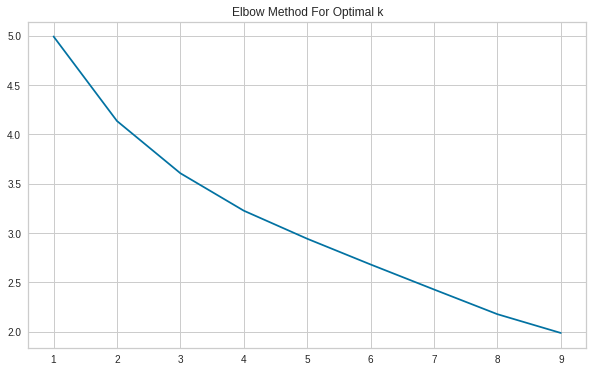

In [37]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood_Name', 1)
sum_of_squared_distances = []

# maximum of 10 clusters
K = range(1,10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=20).fit(toronto_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.title('Elbow Method For Optimal k')

In [38]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
toronto_grouped_clustering

In [45]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [ ]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.rename(columns={'Neighborhood_Name': 'Neighborhood'})
neighborhoods_venues_sorted.head()
toronto_merged = big_df
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

Visualize the clusters

In [57]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h1> Examine each cluster </h1>


<h3> Cluster 1 </h3>

In [51]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,CN Tower,0,Airport Service,Airport Terminal,Sculpture Garden,Harbor / Marina,Plane,Coffee Shop,Boutique,Rental Car Location,Bar,Boat or Ferry
32,King and Spadina,0,Airport Service,Airport Terminal,Sculpture Garden,Harbor / Marina,Plane,Coffee Shop,Boutique,Rental Car Location,Bar,Boat or Ferry
32,Railway Lands,0,Airport Service,Airport Terminal,Sculpture Garden,Harbor / Marina,Plane,Coffee Shop,Boutique,Rental Car Location,Bar,Boat or Ferry
32,Harbourfront West,0,Airport Service,Airport Terminal,Sculpture Garden,Harbor / Marina,Plane,Coffee Shop,Boutique,Rental Car Location,Bar,Boat or Ferry
32,Bathurst Quay,0,Airport Service,Airport Terminal,Sculpture Garden,Harbor / Marina,Plane,Coffee Shop,Boutique,Rental Car Location,Bar,Boat or Ferry
32,South Niagara,0,Airport Service,Airport Terminal,Sculpture Garden,Harbor / Marina,Plane,Coffee Shop,Boutique,Rental Car Location,Bar,Boat or Ferry
32,Island airport,0,Airport Service,Airport Terminal,Sculpture Garden,Harbor / Marina,Plane,Coffee Shop,Boutique,Rental Car Location,Bar,Boat or Ferry


<h3> Cluster 2 </h3>

In [56]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Regent Park,1,Coffee Shop,Bakery,Park,Pub,Breakfast Spot,Café,Theater,Yoga Studio,Event Space,Restaurant
0,Harbourfront,1,Coffee Shop,Bakery,Park,Pub,Breakfast Spot,Café,Theater,Yoga Studio,Event Space,Restaurant
1,Garden District,1,Coffee Shop,Clothing Store,Hotel,Italian Restaurant,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Café,Middle Eastern Restaurant,Lingerie Store
1,Ryerson,1,Coffee Shop,Clothing Store,Hotel,Italian Restaurant,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Café,Middle Eastern Restaurant,Lingerie Store
2,St. James Town,1,Coffee Shop,Café,Restaurant,Park,Gastropub,Italian Restaurant,Cocktail Bar,Bakery,Farmers Market,Pizza Place
3,The Beaches,1,Neighborhood,Health Food Store,Trail,Pub,Yoga Studio,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Electronics Store
4,Berczy Park,1,Coffee Shop,Cocktail Bar,Bakery,Seafood Restaurant,Farmers Market,Cheese Shop,Pharmacy,Beer Bar,Restaurant,Shopping Mall
5,Central Bay Street,1,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Japanese Restaurant,Salad Place,Burger Joint,Bubble Tea Shop,Pizza Place,Poke Place
6,Christie,1,Grocery Store,Café,Park,Coffee Shop,Baby Store,Bank,Candy Store,Italian Restaurant,Restaurant,Nightclub
7,Richmond,1,Coffee Shop,Café,Restaurant,Thai Restaurant,Gym,Clothing Store,Deli / Bodega,Hotel,Salad Place,Cosmetics Shop


<h3> Cluster 3 </h3>

In [54]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Moore Park,2,Restaurant,Park,Summer Camp,Trail,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Yoga Studio
29,Summerhill East,2,Restaurant,Park,Summer Camp,Trail,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Yoga Studio


<h3> Cluster 4 </h3>

In [58]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,The Danforth East,3,Park,Convenience Store,Yoga Studio,Distribution Center,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store
33,Rosedale,3,Park,Playground,Trail,Yoga Studio,Diner,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant


<h1> Results </h1>

The following observations are made after segmenting the neighborhood in Toronto into 4 clusters:
  - Neighborhoods in cluster 1 are the best place to visit for tourists in need of airport service.
  - Cluster 2 and 3 has a high density of bars, coffee shops and restaurants. Tourists who want recreational activities should visit neighorboods in those clusters
  - Tourists who want an escape from urban life could visit neighborhoods in cluster 3 and 4 for their high density of parks and camping areas

<h1> Conclusion </h1>

The purpose of this project was to identify which area in Toronto tourists should visit given their interests. By using the venue information obtained from Foursquare data we have identified all venues and their category for each neighborhood in Toronto, and then generated a one-hot encoded dataframe to represent the frequency of each venue type. Clustering of those locations was then performed in order to create major zones of interest (based on the most common venue types).

Final decision on optimal tourist location will be made by visitors based on their specific interests and the location of their residence.